In [1]:
import random
from os.path import join
import pandas as pd
import xlsxwriter
import openpyxl
import os
import numpy as np
from pandas import Series, ExcelWriter
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc 
from anndata import AnnData
import warnings
warnings.filterwarnings('ignore')

#### Variables

In [6]:
file_path = 'C:/Users/morts/Documents/TAU/Manifold_Project/Data/Serrano_Ravel13_Ravel11_Carter22/ps_res/'

file_name = file_path + 'ps_res_16052023.xlsx'

sheet_abun = 'abundance'
sheet_meta = 'meta'
sheet_umap = 'umap'
sheet_pcoa = 'pcoa'

#### Load data

In [7]:
meta = pd.read_excel(file_name, sheet_name = sheet_meta, index_col = 0)
temp_meta = meta.loc[~ meta['time'].isnull()]
temp_meta['menst'] = np.where(temp_meta['menst'] >= 1 , 1, 0)
print('Temporal samples shape: ' + str(temp_meta.shape))

Temporal samples shape: (3608, 31)


#### Pseudotime diff

In [24]:
temp_meta['BV'] = temp_meta.ABV + temp_meta.SBV
temp_meta['prev_pseudotime'] = temp_meta.groupby('subjectID')['mt_pseudotime'].shift()
temp_meta['ps_diff'] = temp_meta['mt_pseudotime'] - temp_meta['prev_pseudotime']
temp_meta['ps_diff_abs'] = temp_meta['ps_diff'].abs()
temp_meta = pd.merge(temp_meta, temp_meta.groupby('subjectID')['ps_diff_abs'].mean().reset_index(name = 'mean_ps_diff_abs'), on = 'subjectID')

In [25]:
mean_meta = temp_meta.groupby('subjectID')['ps_diff_abs', 'nugent'].mean()
# mean_meta = pd.merge(s[col].sum(skipna = True))

In [26]:
mean_meta = temp_meta.groupby('subjectID').apply(lambda s: pd.Series({ 
        'mean_ps_diff_abs': s['ps_diff_abs'].mean(), 
        'mean_nugent': s['nugent'].mean(),
        'mean_ph': s['ph'].mean(),
        'mean_ps': s['mt_pseudotime'].mean(),
        'count_BV': s['BV'].sum()})).reset_index()
mean_meta['high_nugent'] = np.where(mean_meta.mean_nugent >= 7, 1, 0)
mean_meta['elevated_ph'] = np.where(mean_meta.mean_ph >= 5.5, 1, 0)
mean_meta['ps_diff_eval'] = np.select([mean_meta['mean_ps_diff_abs'] <= 0.025, (mean_meta['mean_ps_diff_abs'] > 0.025) & (mean_meta['mean_ps_diff_abs'] < 0.07), mean_meta['mean_ps_diff_abs'] >= 0.07], ['low', 'medium', 'high'], default = np.nan)

In [27]:
filt_mean_meta = mean_meta[mean_meta['mean_ps'] < 0.9]

In [28]:
filt_temp_meta = temp_meta[temp_meta['subjectID'].isin(filt_mean_meta.subjectID)]

In [29]:
print(filt_temp_meta.shape)
print(temp_meta.shape)

(2411, 37)
(3608, 37)


#### Analysis

In [30]:
temp_meta

,sampleID,subjectID,day,week,time,ph,nugent,menst,subCST,CST,...,BV_bin,root,dpt_pseudotime,mt_pseudotime,BV,prev_pseudotime,ps_diff,ps_diff_abs,mean_ps_diff_abs_x,mean_ps_diff_abs_y
0,UAB075_1_7,UAB075,7.0,1.0,7.0,4.0,0.0,0,I-A,I,...,0,reg,0.573174,0.426826,NaN,NaN,NaN,NaN,0.069429,0.069429
1,UAB075_2_2,UAB075,2.0,2.0,9.0,4.0,0.0,0,I-A,I,...,0,reg,0.628395,0.371605,NaN,0.426826,-0.055221,0.055221,0.069429,0.069429
2,UAB075_2_4,UAB075,4.0,2.0,11.0,4.0,0.0,0,I-A,I,...,0,reg,0.426264,0.573736,NaN,0.371605,0.202132,0.202132,0.069429,0.069429
3,UAB075_2_6,UAB075,6.0,2.0,13.0,4.0,0.0,0,I-A,I,...,0,reg,0.718010,0.281990,NaN,0.573736,-0.291747,0.291747,0.069429,0.069429
4,UAB075_3_1,UAB075,1.0,3.0,15.0,4.4,0.0,1,I-A,I,...,0,reg,0.582440,0.417560,NaN,0.281990,0.135570,0.135570,0.069429,0.069429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3603,m5n715-s521,7058,NaN,NaN,4.0,5.5,NaN,0,IV-B,IV-B,...,0,reg,0.022494,0.977506,NaN,0.931825,0.045681,0.045681,0.065470,0.065470
3604,m5n715-s522,7058,NaN,NaN,7.0,5.5,NaN,0,III-A,III,...,0,reg,0.163575,0.836425,NaN,0.977506,-0.141080,0.141080,0.065470,0.065470
3605,m5n729-s513,7058,NaN,NaN,8.0,0.0,NaN,0,IV-C1,IV-C,...,0,reg,0.021311,0.978689,NaN,0.836425,0.142263,0.142263,0.065470,0.065470
3606,m5n729-s515,7058,NaN,NaN,10.0,5.5,NaN,0,V,V,...,0,reg,0.039914,0.960086,NaN,0.978689,-0.018603,0.018603,0.065470,0.065470


<AxesSubplot:title={'center':'mean_nugent'}, xlabel='ps_diff_eval'>

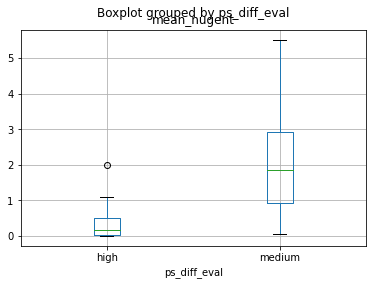

In [20]:
mean_meta.boxplot(by ='ps_diff_eval', column = ['mean_nugent'])

In [21]:
mean_meta.groupby('ps_diff_eval')['high_nugent'].sum()

ps_diff_eval
high      0
medium    0
Name: high_nugent, dtype: int32

<AxesSubplot:title={'center':'mean_ph'}, xlabel='ps_diff_eval'>

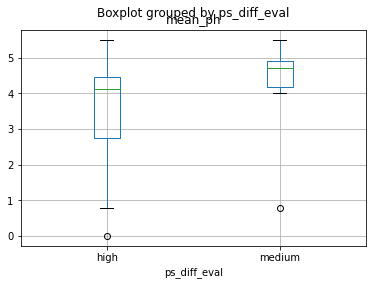

In [22]:
mean_meta.boxplot(by ='ps_diff_eval', column = ['mean_ph'])

<AxesSubplot:title={'center':'count_BV'}, xlabel='ps_diff_eval'>

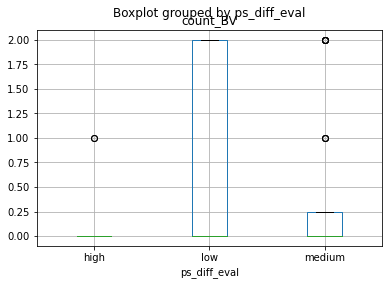

In [85]:
mean_meta.boxplot(by ='ps_diff_eval', column = ['count_BV'])

#### Overlook

In [22]:
def get_scatter(df, x, y):
    fig = px.scatter(df, x = x, y = y, trendline = 'ols', width = 600, height = 400)
    fig.show()
    
    results = px.get_trendline_results(fig)
    
    display(results.iloc[0]["px_fit_results"].params)
    display(results.iloc[0]["px_fit_results"].summary())

    return fig, results

<AxesSubplot:xlabel='subjectID'>

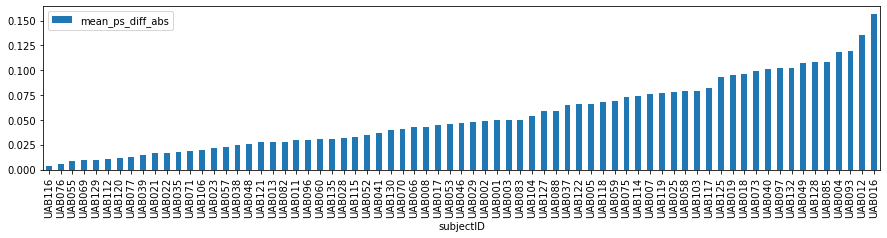

In [61]:
mean_meta.sort_values('mean_ps_diff_abs').plot.bar(x = 'subjectID', y = 'mean_ps_diff_abs', rot = 90, figsize = (15,3))

In [74]:
fig1 = px.scatter(temp_meta.sort_values('mean_ps_diff_abs'), x = "time", y = "mt_pseudotime", color = 'CST', 
                  facet_col = 'subjectID', facet_col_wrap = 4,
                  facet_row_spacing = 0.02, facet_col_spacing = 0.02,
                  width = 1000, height = 1200)

# for axis in fig1.layout:
#     if type(fig1.layout[axis]) == go.layout.YAxis:
#         fig1.layout[axis].title.text = ''
        
# fig1.update_layout(
#     annotations = list(fig1.layout.annotations) + 
#     [go.layout.Annotation(x = -0.07, y = 0.5, font = dict(size = 14),
#             showarrow = False, text = "Pseudotime", textangle = -90, xref = "paper", yref = "paper")])

# fig1.update_traces(marker = dict(size = 8, line = dict(width = 2, color = 'DarkSlateGrey')),
#                   selector = dict(mode = 'markers'))
        
        
fig1.show() 

(array([13., 14., 12.,  5., 12.,  3.,  8.,  2.,  1.,  1.]),
 array([0.00369313, 0.01897036, 0.03424759, 0.04952482, 0.06480205,
        0.08007928, 0.09535652, 0.11063375, 0.12591098, 0.14118821,
        0.15646544]),
 <BarContainer object of 10 artists>)

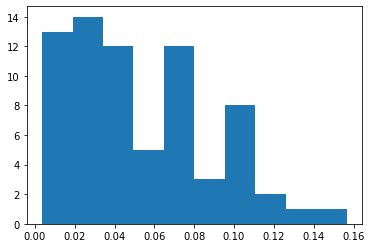

In [21]:
plt.hist(temp_meta['mean_ps_diff_abs'].unique())

In [35]:
print('max: ', mean_meta['mean_ps_diff_abs'].max())
print('min: ', mean_meta['mean_ps_diff_abs'].min())
print('median: ', mean_meta['mean_ps_diff_abs'].median())
print('std: ', mean_meta['mean_ps_diff_abs'].std())

max:  0.15646544274161844
min:  0.003693125645319621
median:  0.04737787912873661
std:  0.035551181611562996


In [79]:
display(temp_meta[temp_meta['subjectID'] == 'UAB025'].mean_ps_diff_abs.unique())

array([0.0785573])

<AxesSubplot:title={'center':'mean_ps_diff_abs'}, xlabel='count_BV'>

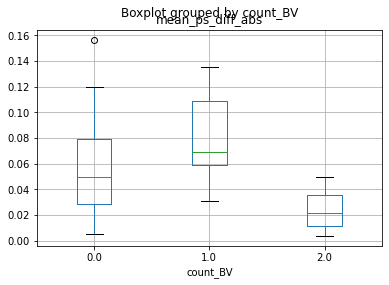

In [32]:
mean_meta.boxplot(by ='count_BV', column = ['mean_ps_diff_abs'])

In [ ]:
mean_meta.boxplot(by ='count_BV', column = ['mean_ps_diff_abs'])

In [87]:
fig, res = get_scatter(temp_meta, 'nugent', 'mean_ps_diff_abs')

array([ 0.07640303, -0.00635684])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.436
Model:                            OLS   Adj. R-squared:                  0.436
Method:                 Least Squares   F-statistic:                     2333.
Date:                Mon, 15 May 2023   Prob (F-statistic):               0.00
Time:                        11:17:44   Log-Likelihood:                 6797.2
No. Observations:                3024   AIC:                        -1.359e+04
Df Residuals:                    3022   BIC:                        -1.358e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0764      0.001    109.029      0.000       0.075       0.078
x1            -0.0064      0.000    -48.304      0.000      -0.007      -0.006
==============================================================================
Omnibus:                       95.035   Durbin-Watson:                   0.993
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              103.507
Skew:                           0.452   Prob(JB):                     3.34e-23
Kurtosis:                       3.071   Cond. No.                         8.19
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [88]:
fig, res = get_scatter(temp_meta, 'ph', 'mean_ps_diff_abs')

array([ 0.14008876, -0.01875405])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.138
Method:                 Least Squares   F-statistic:                     483.6
Date:                Mon, 15 May 2023   Prob (F-statistic):           1.49e-99
Time:                        11:17:54   Log-Likelihood:                 6124.6
No. Observations:                3027   AIC:                        -1.225e+04
Df Residuals:                    3025   BIC:                        -1.223e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1401      0.004     34.616      0.000       0.132       0.148
x1            -0.0188      0.001    -21.991      0.000      -0.020      -0.017
==============================================================================
Omnibus:                      193.066   Durbin-Watson:                   1.014
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              231.286
Skew:                           0.677   Prob(JB):                     5.98e-51
Kurtosis:                       2.998   Cond. No.                         34.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [89]:
fig, res = get_scatter(mean_meta, 'mean_ps_diff_abs', 'mean_nugent')

array([  7.24829978, -66.29147017])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.542
Model:                            OLS   Adj. R-squared:                  0.535
Method:                 Least Squares   F-statistic:                     81.68
Date:                Mon, 15 May 2023   Prob (F-statistic):           2.55e-13
Time:                        11:18:20   Log-Likelihood:                -155.12
No. Observations:                  71   AIC:                             314.2
Df Residuals:                      69   BIC:                             318.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.2483      0.473     15.332      0.000       6.305       8.191
x1           -66.2915      7.335     -9.038      0.000     -80.924     -51.659
==============================================================================
Omnibus:                        0.489   Durbin-Watson:                   1.505
Prob(Omnibus):                  0.783   Jarque-Bera (JB):                0.627
Skew:                          -0.064   Prob(JB):                        0.731
Kurtosis:                       2.558   Cond. No.                         28.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [90]:
fig, res = get_scatter(mean_meta, 'mean_ps_diff_abs', 'mean_ph')

array([ 5.05427097, -7.1730938 ])

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.326
Model:                            OLS   Adj. R-squared:                  0.316
Method:                 Least Squares   F-statistic:                     33.34
Date:                Mon, 15 May 2023   Prob (F-statistic):           2.02e-07
Time:                        11:18:58   Log-Likelihood:                -29.043
No. Observations:                  71   AIC:                             62.09
Df Residuals:                      69   BIC:                             66.61
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.0543      0.080     63.125      0.000       4.895       5.214
x1            -7.1731      1.242     -5.774      0.000      -9.651      -4.695
==============================================================================
Omnibus:                        3.951   Durbin-Watson:                   1.458
Prob(Omnibus):                  0.139   Jarque-Bera (JB):                3.204
Skew:                           0.500   Prob(JB):                        0.201
Kurtosis:                       3.290   Cond. No.                         28.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""